# Uses pocketpartition package

In [ ]:
pip install --upgrade git+https://github.com/blackgauss/pocketpartition.git

  Cloning https://github.com/blackgauss/pocketpartition.git to /tmp/pip-req-build-d7immfah
  Running command git clone --filter=blob:none --quiet https://github.com/blackgauss/pocketpartition.git /tmp/pip-req-build-d7immfah
  Resolved https://github.com/blackgauss/pocketpartition.git to commit d7140761aabd5fd41e39e35243de04024a4989b4
  Preparing metadata (setup.py) ... done


# Imports


In [ ]:
import pocketpartition as pp # For numerical semigroup functions
from functools import partial # For filter function
from collections import deque # For BFS
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Progress Bar


# BFS Implementation

We do a breadth first search through the numerical semigroup tree.
At each genus we take all the semigroups of multiplicity "m" and then compute the number of children. We save this information and then find the average number at each level.

In [ ]:
def multiplicity_filter(node, m):
  if node.multiplicity() == m:
    return True
  else:
    return False

def count_children(node):
  return len(node.get_children())

def bfs_apply_func_at_depth(root, g, func=None, filter_func=None, pbar=None):
    """
    Perform a BFS on a tree, filter nodes at each level, and apply func to the filtered nodes,
    storing the results as [depth, [func(node) for each node at depth]] in the data list.

    :param root: The starting node of the tree.
    :param g: The depth up to which to apply the function.
    :param func: A function to apply to each acceptable node at each depth (optional).
    :param filter_func: A function to filter nodes before applying func (optional).
    :param pbar: A tqdm progress bar object (optional).
    :return: A list of [depth, [func(filtered nodes) at each depth]].
    """
    init_genus = len(root.gaps)
    if g < 0:
        return []

    # Initialize the deque with the root node and its depth (0)
    queue = deque([(root, 0)])
    data = []

    while queue:
        current_level_size = len(queue)
        current_level_nodes = []
        current_depth = queue[0][1]  # Get the current depth from the first element

        # Process all nodes at the current level
        for _ in range(current_level_size):
            current_node, depth = queue.popleft()

            # Process the node only if depth <= g
            if depth <= g:
                # Check if the node passes the filter
                if filter_func is None or filter_func(current_node):
                    current_level_nodes.append(current_node)

                # Add the children to the queue if depth < g and they pass the filter
                if depth < g:
                    for child in current_node.get_children():
                        if filter_func is None or filter_func(child):
                            queue.append((child, depth + 1))

        # Apply the function to the nodes at the current level and store the results
        if func is not None:
            result = [func(node) for node in current_level_nodes]
            data.append([current_depth + init_genus, result])
        else:
            data.append([current_depth + init_genus, current_level_nodes])

        # Update progress bar if provided
        if pbar is not None:
            pbar.update(1)  # Update the progress bar once per depth level

    return data

# Execution

In [ ]:
mult = 5
max_genus = 100

S_root = pp.NumericalSemigroup(gaps=range(1, mult))

# Using tqdm outside the function call
total_levels = max_genus + 1  # The depth + 1 you want to process
with tqdm(total=total_levels, desc="Processing levels") as pbar:
    results = bfs_apply_func_at_depth(S_root, max_genus, count_children, partial(multiplicity_filter, m=mult), pbar=pbar)

# Compute average number of children
avg_children_data = [[item[0], np.mean(item[1])] for item in results]


Processing levels:  65%|██████▌   | 66/101 [02:15<05:18,  9.10s/it]

# Plot Results

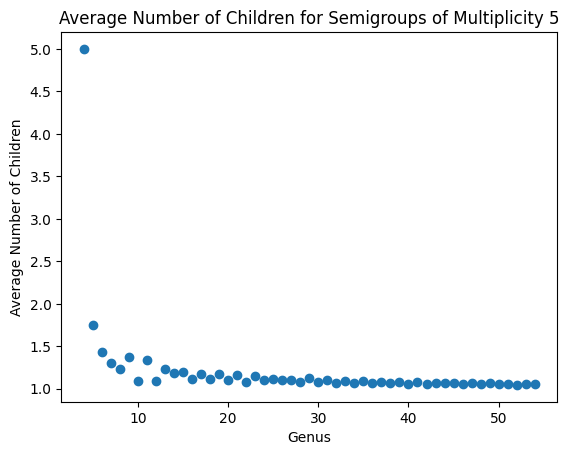

In [ ]:
# Extract the depths and average number of children from the results
depths, avg_children = zip(*avg_children_data)

# Create a scatter plot
plt.scatter(depths, avg_children)

# Set the axis labels and title
plt.xlabel("Genus")
plt.ylabel("Average Number of Children")
plt.title(f"Average Number of Children for Semigroups of Multiplicity {mult}")

# Show the plot
plt.show()
